# Black Scholes Model

#### Amandeep Singh, Filippo Ponzano, Vasilis Valatsos

We attempt to make a program that predicts optional premiums, using the Black-Scholes model, introduced in 1973.

To start off, we first install all the required modules, (We have the cell commented, but in the case that one or more modules aren't installed, uncomment and run once the cell below.)

In [11]:
# pip install -r requirements.txt

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

where the module scipy.stats is not imported here but is needed in the class that we import.

In [15]:
from BlackScholes import Model

Now we begin by initializing the class and by opening the file we wish to use.


In [29]:
bs = Model(1,1,1,1,1)

and we can also create a Brownian motion to simulate a possilbe stock price

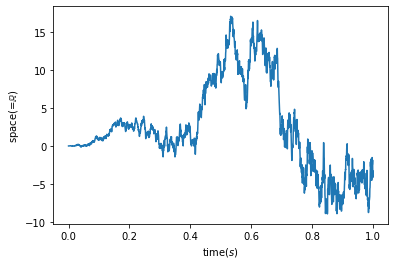

In [27]:
def brownian(t, x=0, y=1):
    mu, sigma = x*t, y*t
    return np.random.normal(mu, sigma)

time = np.linspace(0,1,2000)
path = np.zeros(len(time))

for i in np.arange(1, len(time)):
    path[i] = path[i-1]+brownian(time[i])

plt.plot(time,path)
plt.xlabel('time($s$)')
plt.ylabel('space(=$\mathbb{R}$)')
plt.savefig('1dbrown.png')
plt.show()